In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [46]:
Courrant=0.05
N=700
t_number=700
h = (xright-xleft)/N
tau = Courrant*h

xleft = 0
xright = 2
xmiddle = 1

In [37]:
p1 = 0.7
p2 = 0.8
ro1 = 0.9
ro2 = 1.1
u1 = 1
u2 = 0.6

gamma = 1.4
q = 0.05

In [40]:
#Calculate Exact
r_Exact,p_Exact,v_Exact=Exact_r_p_v(p1,p2,ro1,ro2,u1,u2,gamma,Courrant,N,t_number,xleft,xright,xmiddle)

In [85]:
#Calculate MLP
r_MLP,v_MLP,p_MLP,e_MLP=MLP_r_v_p_e(p1,p2,ro1,ro2,u1,u2,gamma,Courrant,N,t_number,xleft,xright,xmiddle)

In [91]:
#Calculate Mc
((r_Mc,p_Mc,v_Mc,U_Mc,E_Mc),(r_Mc_sm,p_Mc_sm,v_Mc_sm,U_Mc_sm,E_Mc_sm))=McKormac_r_p_v_U_E_nsm_sm(p1,p2,ro1,ro2,u1,u2,gamma,q,Courrant,N,t_number,xleft,xright,xmiddle)

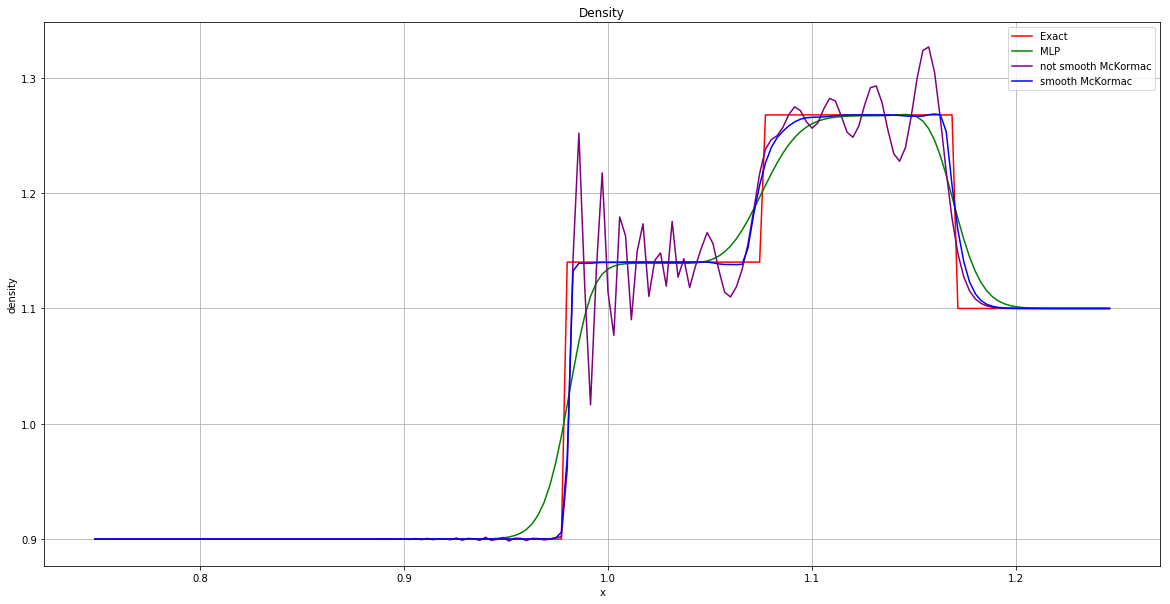

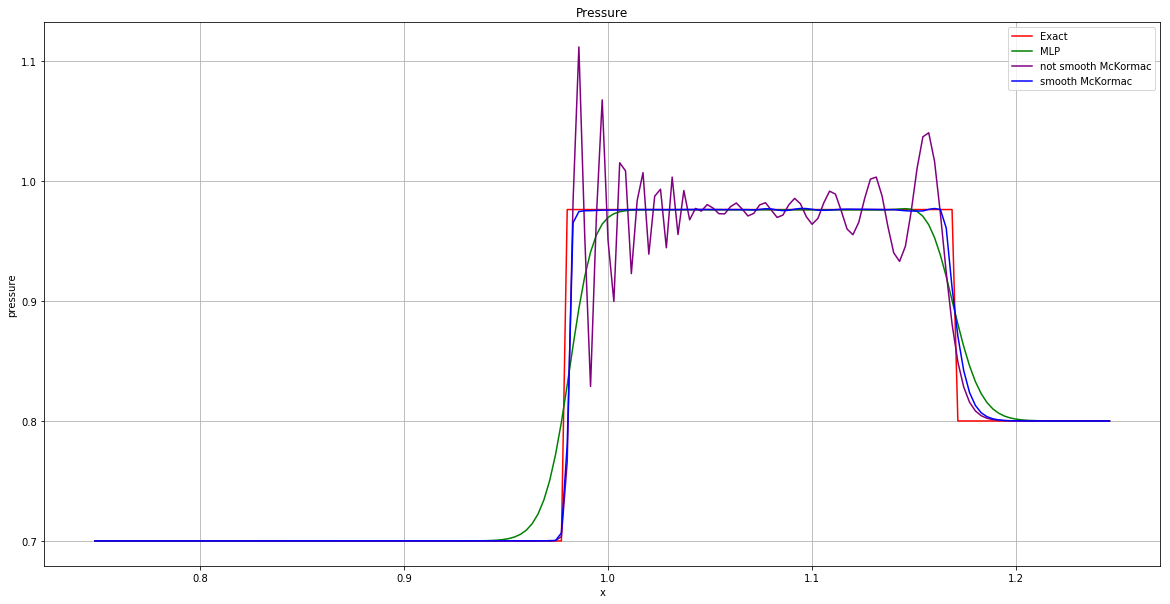

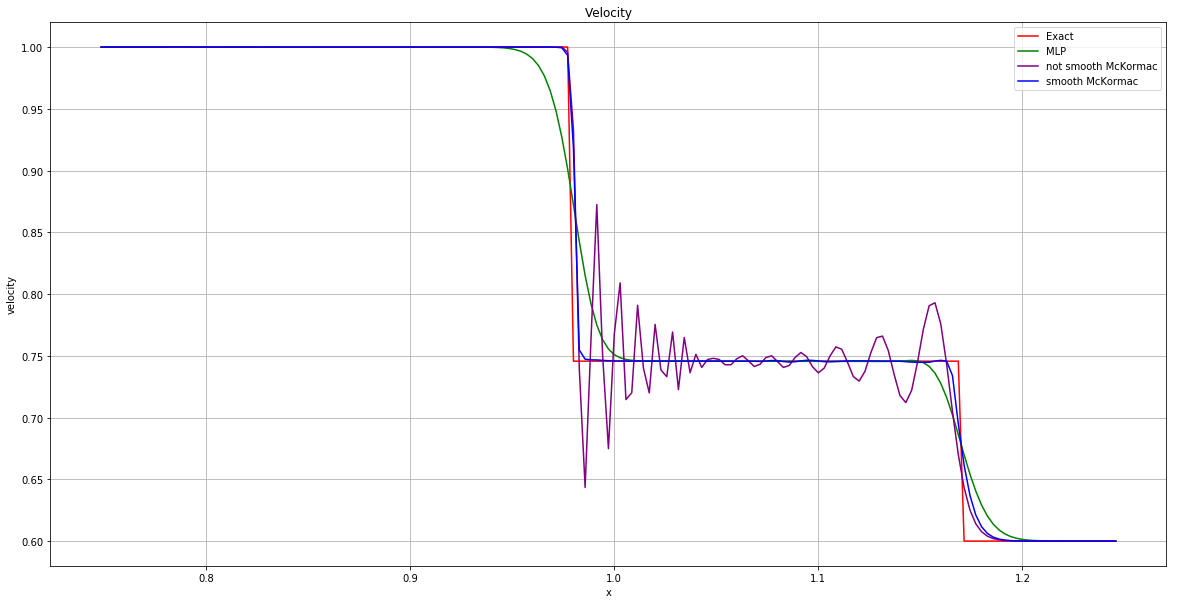

In [141]:
draw(699,0.75,1.25,"Exact","MLP","Mc","smooth Mc","all")

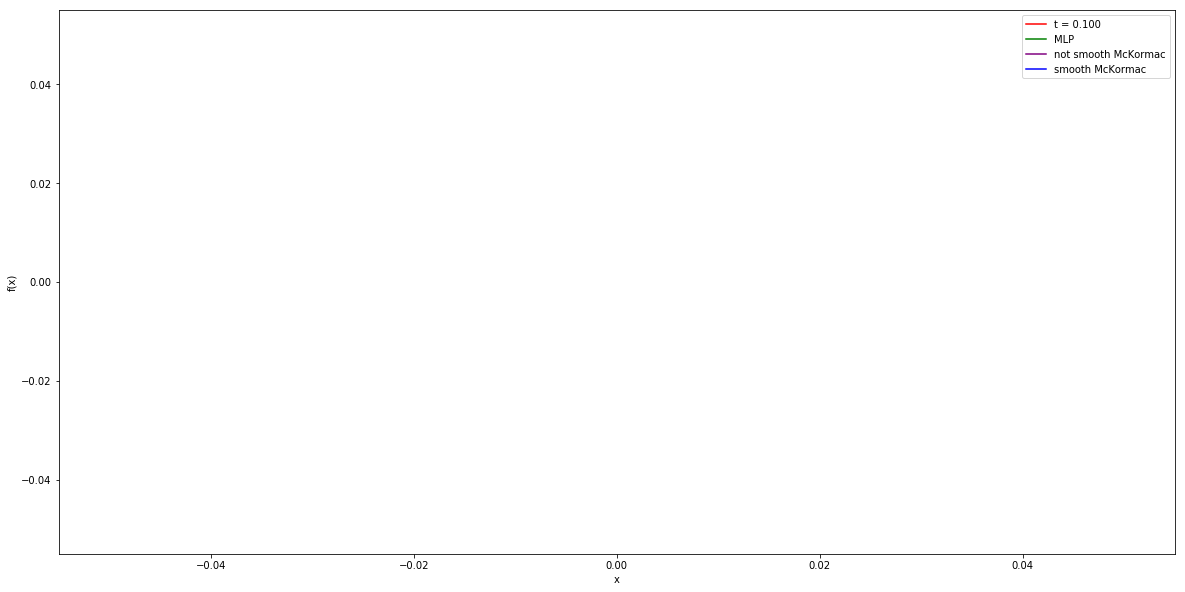

In [162]:
animatePicture(0.75,0.125)

699

# Exact

In [49]:
def Exact_r_p_v(p1,p2,ro1,ro2,u1,u2,gamma,Courrant,N,t_number,xleft,xright,xmiddle):
    
    #Initialization
    f=np.zeros((3,N+1,t_number))
    
    P,U,R1,R2,D1,D2=iterativeProcess(p1,p2,ro1,ro2,u1,u2,gamma)
    
    #Calculation
    for n in range(0, t_number):
        for i in range(0,N+1):
            x=i*h
            t=n*tau
            if(x<xmiddle+D1*t):
                f[0,i,n]=ro1
                f[1,i,n]=p1
                f[2,i,n]=u1
            elif(x>xmiddle+D2*t):
                f[0,i,n]=ro2
                f[1,i,n]=p2
                f[2,i,n]=u2
            else:
                f[1,i,n]=P
                f[2,i,n]=U
                if (x<xmiddle+U*t):
                    f[0,i,n]=R1
                else:
                    f[0,i,n]=R2
    return f[0,:,:],f[1,:,:],f[2,:,:]

In [50]:
def iterativeProcess(p1,p2,ro1,ro2,u1,u2,gamma):
    P=(p1+p2)/2
    с1=np.sqrt(p1*gamma/ro1)
    c2=np.sqrt(p2*gamma/ro2)
    for _ in range(0,5):
        a1=np.sqrt(ro1*((gamma+1)*P+(gamma-1)*p1)/2)
        a2=np.sqrt(ro2*((gamma+1)*P+(gamma-1)*p2)/2)
        P=(a2*p1+a1*p2+a1*a2*(u1-u2))/(a1+a2)
    U=(a1*u1+a2*u2+p1-p2)/(a1+a2)
    R1=ro1*((gamma+1)*P+(gamma-1)*p1)/((gamma-1)*P+(gamma+1)*p1)
    R2=ro2*((gamma+1)*P+(gamma-1)*p2)/((gamma-1)*P+(gamma+1)*p2)
    D1=u1-a1/ro1
    D2=u2+a2/ro2
    return P,U,R1,R2,D1,D2

# Method of Large Particles

In [79]:
def MLP_r_v_p_e(p1,p2,ro1,ro2,u1,u2,gamma,Courrant,N,t_number,xleft,xright,xmiddle):
    
    #Initialization
    f=np.zeros((3,N+1,t_number))
    
    initial_MLP(f)
    
    #Calculation
    for n in range(0, t_number-1):
        f[:,:,n+1]=nextLayer_MLP(f,n)
    r_v_p=getOriginal_r_v_p_MLP(f)
    return r_v_p[0,:,:],r_v_p[1,:,:],r_v_p[2,:,:],f[2,:,:]

In [68]:
def initial_MLP(f):
    f[0,:int((xmiddle-xleft)/h)+1,0] = ro1
    f[0,int((xmiddle-xleft)/h)+1:,0] = ro2
    
    f[1,:int((xmiddle-xleft)/h)+1,0] = u1
    f[1,int((xmiddle-xleft)/h)+1:,0] = u2
    
    f[2,:int((xmiddle-xleft)/h)+1,0] = p1/(ro1*(gamma-1)) + u1**2/2
    f[2,int((xmiddle-xleft)/h)+1:,0] = p2/(ro2*(gamma-1)) + u2**2/2

def edge_MLP(f):
    f[0,0] = ro1
    f[0,N] = ro2
    
    f[1,0] = u1
    f[1,N] = u2
    
    f[2,0] = p1/(ro1*(gamma-1)) + u1**2/2
    f[2,N] = p2/(ro2*(gamma-1)) + u2**2/2

In [69]:
def Eiler(f,p):
    f_eil=np.zeros((3, N+1))
    f_eil[0]=f[0]
    u=f[1]
    for i in range(1,N):
        p_p=(p[i]+p[i+1])/2
        p_m=(p[i]+p[i-1])/2
        u_p=(u[i]+u[i+1])/2
        u_m=(u[i]+u[i-1])/2
        f_eil[1,i]=f[1,i]-Courrant*(p_p-p_m)/f[0,i]
        f_eil[2,i]=f[2,i]-Courrant*(p_p*u_p-p_m*u_m)/f[0,i]
    return f_eil

In [78]:
def nextLayer_MLP(f,n):
    f0=f[:,:,n]
    f1 = np.zeros((3, N+1))
    D_p=np.zeros((N+1))
    D_m=np.zeros((N+1))
    Y_p=np.zeros((N+1))
    Y_m=np.zeros((N+1))
    
    p=f0[0,:]*(f0[2,:]-f0[1,:]**2/2)*(gamma-1)
    
    #Eiler
    f_eil=Eiler(f0,p)
    edge_MLP(f_eil)
    for i in range(1,N):
        u_p=(f_eil[1,i]+f_eil[1,i+1])/2
        u_m=(f_eil[1,i]+f_eil[1,i-1])/2
        if(u_p>=0):
            D_p[i]=0
            Y_p[i]=f0[0,i]*np.abs(u_p)
        else:
            D_p[i]=1
            Y_p[i]=f0[0,i+1]*np.abs(u_p)
        if(u_m>=0):
            D_m[i]=1
            Y_m[i]=f0[0,i-1]*np.abs(u_m)
        else:
            D_m[i]=0
            Y_m[i]=f0[0,i]*np.abs(u_m)
        
        f1[0,i]=f0[0,i]+2*Courrant*((D_m[i]-0.5)*Y_m[i]+(D_p[i]-0.5)*Y_p[i])
        
        f1[1,i]=f_eil[1,i]*f0[0,i]/f1[0,i]+(
            f_eil[1,i]*((D_m[i]-1)*Y_m[i]+(D_p[i]-1)*Y_p[i])+
                f_eil[1,i-1]*D_m[i]*Y_m[i]+f_eil[1,i+1]*D_p[i]*Y_p[i])*Courrant/f1[0,i]
        
        f1[2,i]=f_eil[2,i]*f0[0,i]/f1[0,i]+(
            f_eil[2,i]*((D_m[i]-1)*Y_m[i]+(D_p[i]-1)*Y_p[i])+
                f_eil[2,i-1]*D_m[i]*Y_m[i]+f_eil[2,i+1]*D_p[i]*Y_p[i])*Courrant/f1[0,i]
    edge_MLP(f1)
    return f1

In [71]:
def getOriginal_r_v_p_MLP(f):
    originals=np.zeros_like(f)
    originals[0]=f[0]
    originals[1]=f[1]
    originals[2]=f[0]*(f[2]-f[1]**2/2)*(gamma-1)
    return originals

# Method of McKormac

In [90]:
def McKormac_r_p_v_U_E_nsm_sm(p1,p2,ro1,ro2,u1,u2,gamma,q,Courrant,N,t_number,xleft,xright,xmiddle):
    
    #Initialization
    f=np.zeros((3,N+1,t_number))
    f_sm=np.zeros((3,N+1,t_number))
    
    
    initial_McKormac(f)
    initial_McKormac(f_sm)
    
    #Calculation
    for n in range(0, t_number-1):
        f[:,:,n+1]=nextLayer_McKormac(f,n,"not smooth")
        f_sm[:,:,n+1]=nextLayer_McKormac(f_sm,n,"smooth")
    r_p_v=getOriginal_r_p_v_McKormac(f)
    r_p_v_sm=getOriginal_r_p_v_McKormac(f_sm)
    return ((r_p_v[0,:,:],r_p_v[1,:,:],r_p_v[2,:,:],f[1,:,:],f[2,:,:]),(r_p_v_sm[0,:,:],r_p_v_sm[1,:,:],r_p_v_sm[2,:,:],f_sm[1,:,:],f_sm[2,:,:]))

In [81]:
def F(f,i):
    F=np.zeros(3)
    F[0]=f[1,i]
    F[1]=f[1,i]**2/f[0,i] + (f[2,i]-f[1,i]**2/(2*f[0,i]))*(gamma-1)
    F[2]=(f[1,i]/f[0,i])*(f[2,i]+(f[2,i]-f[1,i]**2/(2*f[0,i]))*(gamma-1))
    return F

In [82]:
def initial_McKormac(f):
    f[0,:int((xmiddle-xleft)/h)+1,0] = ro1
    f[0,int((xmiddle-xleft)/h)+1:,0] = ro2
    
    f[1,:int((xmiddle-xleft)/h)+1,0] = ro1*u1
    f[1,int((xmiddle-xleft)/h)+1:,0] = ro2*u2
    
    f[2,:int((xmiddle-xleft)/h)+1,0] = p1/(gamma-1) + (ro1*u1)**2/(2*ro1)
    f[2,int((xmiddle-xleft)/h)+1:,0] = p2/(gamma-1) + (ro2*u2)**2/(2*ro2)

def edge_McKormac(f):
    f[0,0] = ro1
    f[0,N] = ro2
    
    f[1,0] = ro1*u1
    f[1,N] = ro2*u2
    
    f[2,0] = p1/(gamma-1) + (ro1*u1)**2/(2*ro1)
    f[2,N] = p2/(gamma-1) + (ro2*u2)**2/(2*ro2)

In [87]:
def nextLayer_McKormac(f,n,smooth):
    f0=f[:,:,n]
    f_middle = np.zeros((3, N+1))
    f1 = np.zeros((3, N+1))
    f1_smooth = np.zeros((3, N+1))
    Q_minus = np.zeros((3))
    Q_plus = np.zeros((3))
    
    edge_McKormac(f0)
    edge_McKormac(f_middle)
    edge_McKormac(f1)
    edge_McKormac(f1_smooth)
    
    for i in range(1, N):
        f_middle[:,i] = f0[:,i]-Courrant*(F(f0, i+1) - F(f0,i))
        f1[:,i] = (f0[:,i] + f_middle[:,i])/2 - (Courrant/2)*(F(f_middle,i) - F(f_middle,i-1))
    
    if smooth=="not smooth":
        return f1
    if smooth=="smooth":
        for j in range(1, N):
            if (j-2)<0:
                j_m2 = 0
            else:
                j_m2 = j-2
            if (j+2)>N:
                j_p2 = N
            else:
                j_p2 = j+2            
            
            Dmm = f1[0,j-1] - f1[0,j_m2]
            Dm = f1[0,j] - f1[0,j-1]
            Dp = f1[0,j+1] - f1[0,j]
            Dpp = f1[0,j_p2] - f1[0,j+1]
            if (Dmm*Dm <= 0) or (Dm*Dp <= 0):
                Q_minus[:]  = f1[:,j] - f1[:,j-1]
            else:
                Q_minus[:]  = 0           
            if (Dm*Dp <= 0) or (Dp*Dpp <= 0):
                Q_plus[:]  = f1[:,j+1] - f1[:,j]                
            else:
                Q_plus[:]  = 0       
    
            f1_smooth[:,j] = f1[:,j] + q*(Q_plus[:]-Q_minus[:])
                
        return f1_smooth

In [84]:
def getOriginal_r_p_v_McKormac(f):
    originals=np.zeros_like(f)
    originals[0]=f[0]
    originals[1]=(f[2]-f[1]**2/(2*f[0]))*(gamma-1)
    originals[2]=f[1]/f[0]
    return originals

# Presentation

In [140]:
def draw(t,Xmin,Xmax,Exact,MLP,Mc,smMc,tp):
    x = np.zeros((N+1))  
    for i in range(0, N+1):
        x[i] = i*h
    imin=(int)(Xmin/h)
    imax=(int)(Xmax/h)
    
    if tp=="density" or tp=="all":
        fig1 = plt.figure(figsize=(20,10))
        ax1 = fig1.add_subplot(1, 1, 1)
        ax1.set_title('Density')
        if Exact=="Exact":
            ax1.plot(x[imin:imax], r_Exact[imin:imax,t], color='red',label='Exact')
        if MLP=="MLP":
            ax1.plot(x[imin:imax],r_MLP[imin:imax,t],color='green',label='MLP')
        if Mc=="Mc":
            ax1.plot(x[imin:imax],r_Mc[imin:imax,t],color='purple',label='not smooth McKormac')
        if smMc=="smooth Mc":
            ax1.plot(x[imin:imax],r_Mc_sm[imin:imax,t],color='blue',label='smooth McKormac')
        ax1.legend()
        ax1.set_xlabel('x')
        ax1.set_ylabel('density')
        ax1.grid() 
    
    if tp=="pressure" or tp=="all":
        fig2 = plt.figure(figsize=(20,10))
        ax2 = fig2.add_subplot(1, 1, 1)
        ax2.set_title('Pressure')
        if Exact=="Exact":
            ax2.plot(x[imin:imax], p_Exact[imin:imax,t], color='red',label='Exact')
        if MLP=="MLP":
            ax2.plot(x[imin:imax],p_MLP[imin:imax,t],color='green',label='MLP')
        if Mc=="Mc":
            ax2.plot(x[imin:imax],p_Mc[imin:imax,t],color='purple',label='not smooth McKormac')
        if smMc=="smooth Mc":
            ax2.plot(x[imin:imax],p_Mc_sm[imin:imax,t],color='blue',label='smooth McKormac')
        ax2.legend()
        ax2.set_xlabel('x')
        ax2.set_ylabel('pressure')
        ax2.grid()
        
    if tp=="velocity" or tp=="all":
        fig3 = plt.figure(figsize=(20,10))
        ax3 = fig3.add_subplot(1, 1, 1)
        ax3.set_title('Velocity')
        if Exact=="Exact":
            ax3.plot(x[imin:imax], v_Exact[imin:imax,t], color='red',label='Exact')
        if MLP=="MLP":
            ax3.plot(x[imin:imax],v_MLP[imin:imax,t],color='green',label='MLP')
        if Mc=="Mc":
            ax3.plot(x[imin:imax],v_Mc[imin:imax,t],color='purple',label='not smooth McKormac')
        if smMc=="smooth Mc":
            ax3.plot(x[imin:imax],v_Mc_sm[imin:imax,t],color='blue',label='smooth McKormac')
        ax3.legend()
        ax3.set_xlabel('x')
        ax3.set_ylabel('velocity')
        ax3.grid() 
    

In [161]:
def animatePicture(Xmin,Xmax):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.zeros((N+1))  
    for i in range(0, N+1):
        x[i] = i*h
    imin=(int)(Xmin/h)
    imax=(int)(Xmax/h)

    l1, = ax.plot(x[imin:imax], r_Exact[imin:imax,-1], color='red',label='Exact')
    l2, = ax.plot(x[imin:imax],r_MLP[imin:imax,-1],color='green',label='MLP')
    l3, = ax.plot(x[imin:imax],r_Mc[imin:imax,-1],color='purple',label='not smooth McKormac')
    l4, = ax.plot(x[imin:imax],r_Mc_sm[imin:imax,-1],color='blue',label='smooth McKormac')

    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")

    def animate(i):
        l1.set_data(x[imin:imax], r_Exact[imin:imax,i])
        l1.set_label('t = ' + '%.3f' %(i * tau))
        l2.set_data(x[imin:imax], r_MLP[imin:imax,i])
        l3.set_data(x[imin:imax],r_Mc[imin:imax,i])
        l4.set_data(x[imin:imax], r_Mc_sm[imin:imax,i])

        legend = plt.legend(loc='upper right')
        return l1, l2,l2,l3,l4,legend

    ani = animation.FuncAnimation(fig, animate, frames= np.linspace(0, t_number-1, 699).astype(int), interval=50)
    HTML(ani.to_jshtml())

In [ ]:
def draw_Exact(r_Exact,p_Exact,v_Exact,t):
    x = np.zeros((N+1))  
    for i in range(0, N+1):
        x[i] = i*h
        
        
    fig1 = plt.figure(figsize=(20,7))
    ax1 = fig1.add_subplot(1, 1, 1)
    ax1.plot(x, r_Exact[:,t], color='deeppink')
    ax1.set_xlabel('x')
    ax1.set_ylabel('density')
    ax1.grid() 
    
    fig2 = plt.figure(figsize=(20,7))
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.plot(x, p_Exact[:,t], color='blue')
    ax2.set_xlabel('x')
    ax2.set_ylabel('pressure')
    ax2.grid() 

    
    fig3 = plt.figure(figsize=(20,7))
    ax3 = fig3.add_subplot(1,1, 1)
    ax3.plot(x, v_Exact[:,t], color='purple')
    ax3.set_xlabel('x')
    ax3.set_ylabel('velocity')
    ax3.grid() 
